In [212]:
import csv
import json

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from xgboost import XGBClassifier

from typing import List, Dict

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

import lightgbm as lgb

In [5]:
def soil_type_2_elu(soil_type: int) -> int:
    assert 0 < soil_type < 41, \
        "Soil type out of boundary 1~40."
    code_dict = [
        2702, 2703, 2704, 2705, 2706,
        2717, 3501, 3502, 4201, 4703,
        4704, 4744, 4758, 5101, 5151,
        6101, 6102, 6731, 7101, 7102,
        7103, 7201, 7202, 7700, 7701,
        7702, 7709, 7710, 7745, 7746,
        7755, 7756, 7757, 7790, 8703,
        8707, 8708, 8771, 8772, 8776,
        ]
    return code_dict[soil_type - 1]


def get_climatic_zone(elu: int) -> int:
    res = elu // 1000
    assert 0 < res <= 8, "Climatic zone code out of boundary 1~8."
    return res


def get_geologic_zone(elu: int) -> int:
    res = elu % 1000 // 100
    assert 0 < res <= 8, "Geologic zone code out of boundary 1~8."
    return res


def get_third_digit(elu: int) -> int:
    return elu % 100 // 10


def get_fourth_digit(elu: int) -> int:
    return elu % 10


def preprocess(df: pd.DataFrame, mode: str = "train") -> List[np.ndarray]:
    """
    Preprocess the dataframe and return [X, y] without reshuffling nor rescaling.
    X is of shape (n,d+2) and y is of shape (n).
    The first column of X contains the ID of each record,
    whilst the second column contains the area code of each record.
    :param mode whether "train" or "test"
    """

    # soil types
    df.insert(loc=0, column="Soil_Type", value=0)
    for i in range(1, 41):
        column_name = "Soil_Type" + str(i)
        df.loc[df[column_name] == 1, "Soil_Type"] = i
        df.drop(column_name, axis=1, inplace=True)

    df["elu"] = [soil_type_2_elu(i) for i in df["Soil_Type"]]
    df.drop("Soil_Type", axis=1, inplace=True)

    df["climatic_zone"] = [get_climatic_zone(i) for i in df["elu"]]
    df["geologic_zone"] = [get_geologic_zone(i) for i in df["elu"]]
    df["third_digit"] = [get_third_digit(i) for i in df["elu"]]
    df["fourth_digit"] = [get_fourth_digit(i) for i in df["elu"]]
    df.drop("elu", axis=1, inplace=True)

    # wilderness area
    df.insert(loc=0, column="Wilderness_Area", value=0)
    for i in range(1, 5):
        column_name = "Wilderness_Area" + str(i)
        df.loc[df[column_name] == 1, "Wilderness_Area"] = i
        df.drop(column_name, axis=1, inplace=True)

    # reformat
    ids = df["Id"].to_numpy()
    df.drop("Id", axis=1, inplace=True)

    if mode == "train":
        y = df["Cover_Type"].to_numpy()
        df.drop("Cover_Type", axis=1, inplace=True)
    elif mode == "test":
        y = None
    else:
        raise AssertionError("Unexpected mode, try \"train\" or \"test\" instead. ")

    areas = df["Wilderness_Area"].to_numpy()
    df.drop("Wilderness_Area", axis=1, inplace=True)


    X = df.to_numpy()

    # one hot encode
    enc = OneHotEncoder(categories=[np.arange(1, 9), np.arange(1, 9), np.arange(0, 10), np.arange(0, 10)])
    enc.fit(X[:, -4:])

    X = np.concatenate((
        ids.reshape(-1, 1),
        areas.reshape(-1, 1),
        X[:, :-4],
        enc.transform(X[:, -4:]).toarray()
    ), axis=1)

    return [X, y]

In [6]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataframe and return [X, y] without reshuffling nor rescaling.
    X is of shape (n,d+2) and y is of shape (n).
    The first column of X contains the ID of each record,
    whilst the second column contains the area code of each record.
    :param mode whether "train" or "test"
    """

    # soil types
    df.insert(loc=0, column="Soil_Type", value=0)
    for i in range(1, 41):
        column_name = "Soil_Type" + str(i)
        df.loc[df[column_name] == 1, "Soil_Type"] = i
        df.drop(column_name, axis=1, inplace=True)

    df["elu"] = [soil_type_2_elu(i) for i in df["Soil_Type"]]
    df.drop("Soil_Type", axis=1, inplace=True)

    df["climatic_zone"] = [get_climatic_zone(i) for i in df["elu"]]
    df["geologic_zone"] = [get_geologic_zone(i) for i in df["elu"]]
    df["third_digit"] = [get_third_digit(i) for i in df["elu"]]
    df["fourth_digit"] = [get_fourth_digit(i) for i in df["elu"]]
    # df.drop("elu", axis=1, inplace=True)

    # wilderness area
    df.insert(loc=0, column="Wilderness_Area", value=0)
    for i in range(1, 5):
        column_name = "Wilderness_Area" + str(i)
        df.loc[df[column_name] == 1, "Wilderness_Area"] = i
        df.drop(column_name, axis=1, inplace=True)

    return df

In [7]:
df_train = pd.read_csv("./data/train.csv")
df_train = preprocess_df(df_train)

In [8]:
df_train

Wilderness_Area      Id  Elevation  Aspect  Slope  \
0                    1  242642       2881     130     22   
1                    3  309891       3005     351     14   
2                    1  287847       3226      63     14   
3                    2  516307       3298     317      8   
4                    1  124860       3080      35      6   
...                ...     ...        ...     ...    ...   
15115                3  475155       3328     321     13   
15116                2  514378       3455      37      5   
15117                1  368425       3279      90     14   
15118                2  537844       3589     357      9   
15119                3  463634       3385     345     15   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
0                                   210                              54   
1                                   242                             -16   
2                                   618                               2   
3                                   661                              60   
4                                   175                              26   
...                                 ...                             ...   
15115                               323                              12   
15116                               841                              92   
15117                               404                             113   
15118                               418                              52   
15119                               350                              76   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
0                                 1020            250             221   
1                                 1371            194             215   
2                                 1092            232             210   
3                                  752            198             233   
4                                 3705            219             227   
...                                ...            ...             ...   
15115                             5109            186             227   
15116                              939            220             229   
15117                             1513            240             218   
15118                             1868            205             223   
15119                             3625            190             216   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  Cover_Type   elu  \
0                 88                                 342           1  7746   
1                159                                 842           1  7700   
2                107                                2018           1  7745   
3                174                                1248           1  7202   
4                144                                2673           1  7700   
...              ...                                 ...         ...   ...   
15115            180                                3151           7  8771   
15116            146                                 362           7  8776   
15117            105                                1503           7  7745   
15118            155                                1657           7  8776   
15119            164                                3327           7  8776   

       climatic_zone  geologic_zone  third_digit  fourth_digit  
0                  7              7            4             6  
1                  7              7            0             0  
2                  7              7            4             5  
3                  7              2            0             2  
4                  7              7            0             0  
...              ...            ...          ...           ...  
15115              8              7            7             1  
15116              8              7            7   

In [10]:
df_train['Cover_Type'].value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

# uniforme distribution

array([[<AxesSubplot: title={'center': 'Wilderness_Area'}>,
        <AxesSubplot: title={'center': 'Id'}>,
        <AxesSubplot: title={'center': 'Elevation'}>,
        <AxesSubplot: title={'center': 'Aspect'}>],
       [<AxesSubplot: title={'center': 'Slope'}>,
        <AxesSubplot: title={'center': 'Horizontal_Distance_To_Hydrology'}>,
        <AxesSubplot: title={'center': 'Vertical_Distance_To_Hydrology'}>,
        <AxesSubplot: title={'center': 'Horizontal_Distance_To_Roadways'}>],
       [<AxesSubplot: title={'center': 'Hillshade_9am'}>,
        <AxesSubplot: title={'center': 'Hillshade_Noon'}>,
        <AxesSubplot: title={'center': 'Hillshade_3pm'}>,
        <AxesSubplot: title={'center': 'Horizontal_Distance_To_Fire_Points'}>],
       [<AxesSubplot: title={'center': 'Cover_Type'}>,
        <AxesSubplot: title={'center': 'elu'}>,
        <AxesSubplot: title={'center': 'climatic_zone'}>,
        <AxesSubplot: title={'center': 'geologic_zone'}>],
       [<AxesSubplot: title={'cen

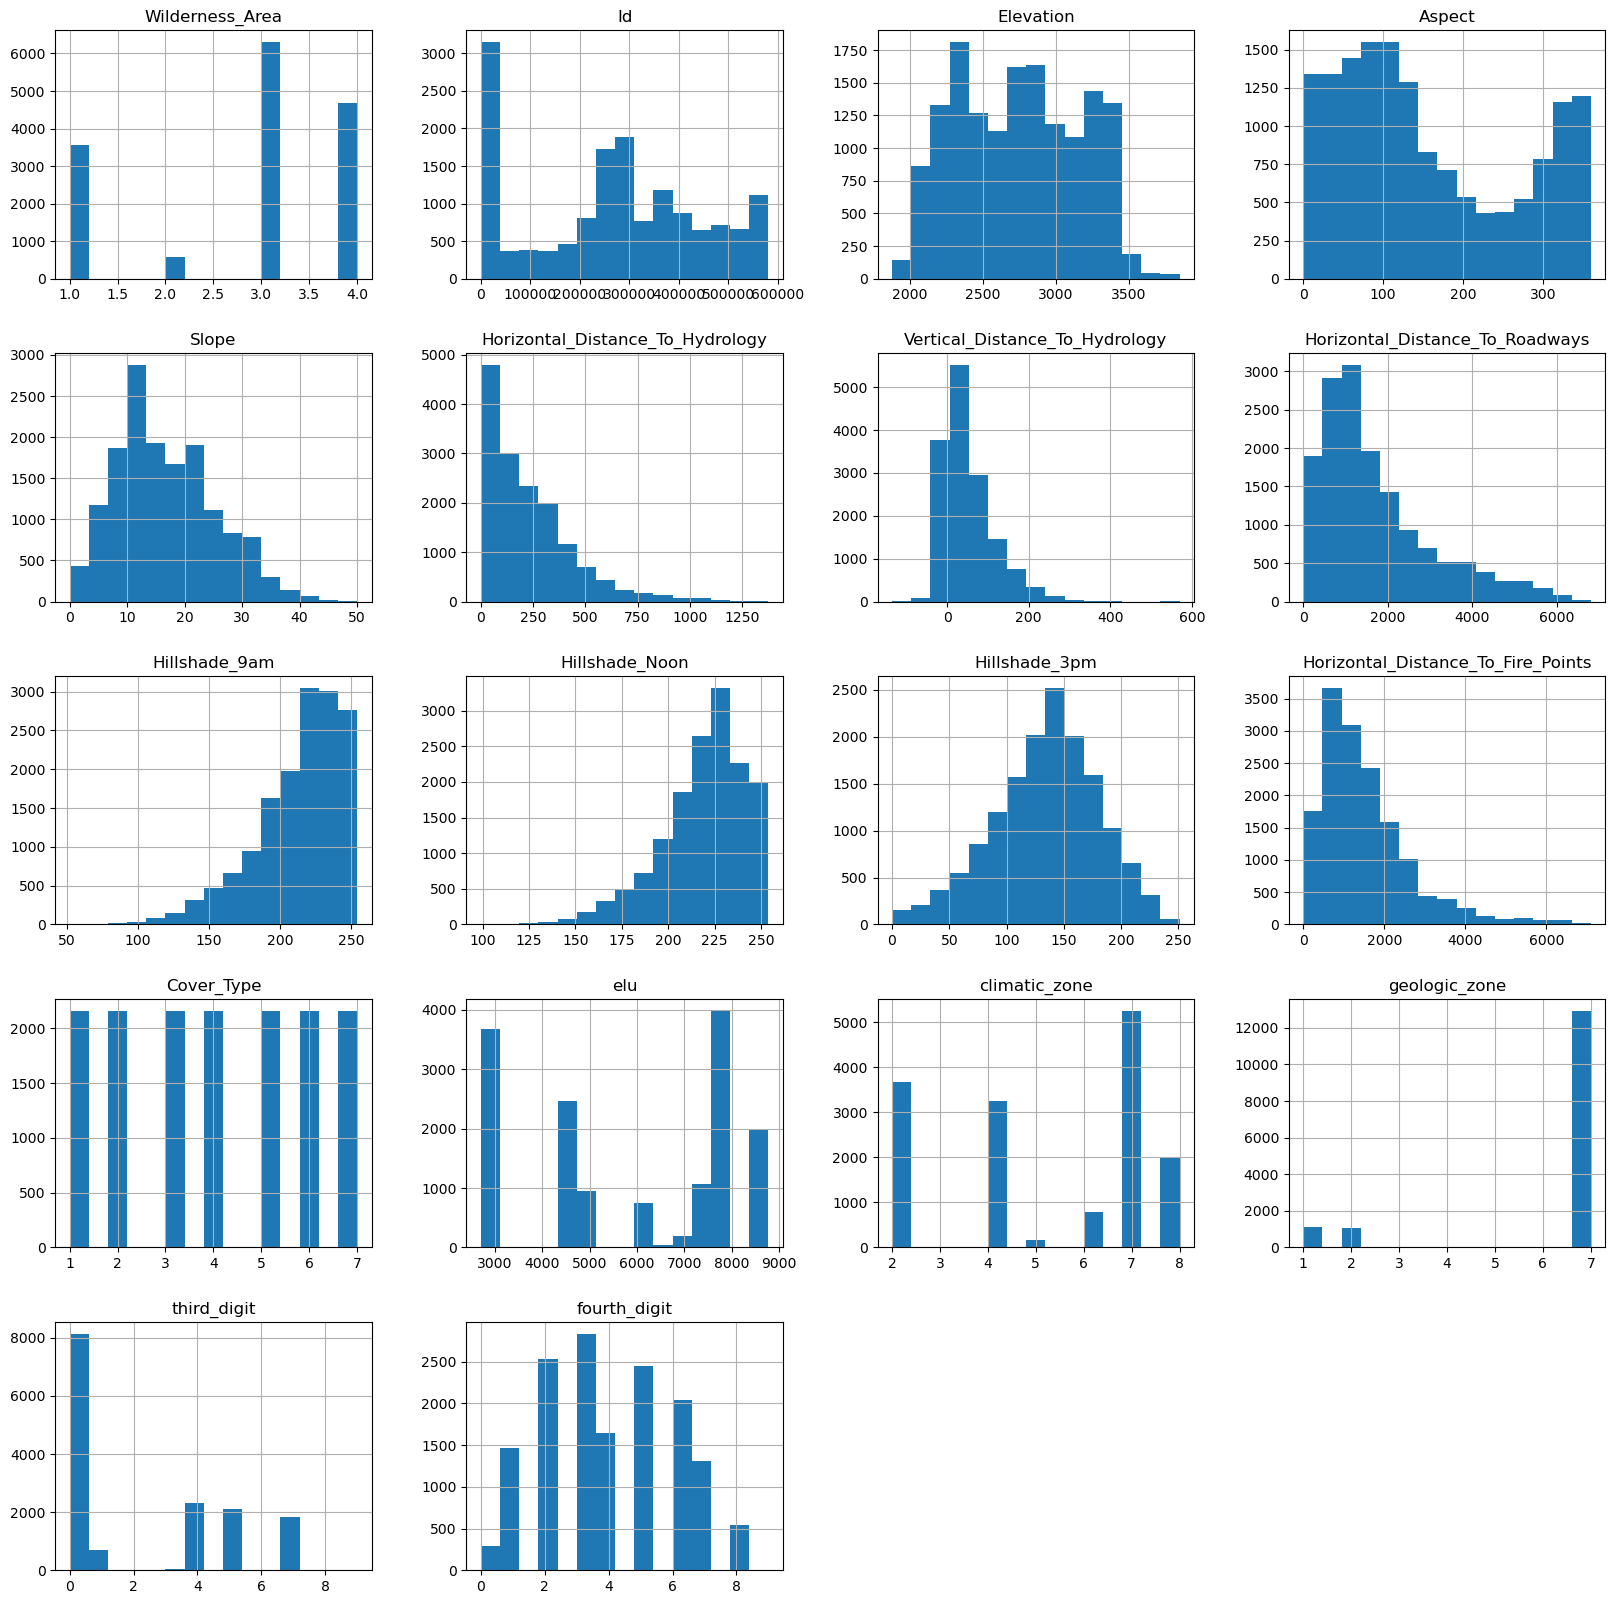

In [11]:
df_train.hist(figsize=(20,20),bins=15)

Wilderness_Area        Id  Elevation  \
Wilderness_Area                            1.000000  0.021545   0.623777   
Id                                         0.021545  1.000000   0.370983   
Elevation                                  0.623777  0.370983   1.000000   
Aspect                                     0.138938  0.048678   0.018549   
Slope                                      0.255257  0.024846   0.322898   
Horizontal_Distance_To_Hydrology           0.118009  0.194436   0.422743   
Vertical_Distance_To_Hydrology             0.093315  0.089306   0.126389   
Horizontal_Distance_To_Roadways            0.465730  0.026915   0.580849   
Hillshade_9am                              0.191093  0.092125   0.110033   
Hillshade_Noon                             0.083778  0.079311   0.225860   
Hillshade_3pm                              0.064577  0.122254   0.086216   
Horizontal_Distance_To_Fire_Points         0.508791  0.031485   0.443014   
Cover_Type                                 0.209669  0.034812   0.014241   
elu                                        0.622997  0.169263   0.795584   
climatic_zone                              0.615830  0.161741   0.778175   
geologic_zone                              0.039689  0.051941   0.028446   
third_digit                                0.460700  0.137578   0.704628   
fourth_digit                               0.041001  0.042229   0.009661   

                                      Aspect     Slope  \
Wilderness_Area                     0.138938  0.255257   
Id                                  0.048678  0.024846   
Elevation                           0.018549  0.322898   
Aspect                              1.000000  0.036117   
Slope                               0.036117  1.000000   
Horizontal_Distance_To_Hydrology    0.034479  0.067151   
Vertical_Distance_To_Hydrology      0.042821  0.252417   
Horizontal_Distance_To_Roadways     0.044150  0.285387   
Hillshade_9am                       0.590290  0.195783   
Hillshade_Noon                      0.313553  0.613979   
Hillshade_3pm                       0.624801  0.335116   
Horizontal_Distance_To_Fire_Points  0.073553  0.241632   
Cover_Type                          0.009439  0.086536   
elu                                 0.003287  0.277021   
climatic_zone                       0.001198  0.296344   
geologic_zone                       0.046443  0.263240   
third_digit                         0.029870  0.127482   
fourth_digit                        0.052116  0.146649   

                                    Horizontal_Distance_To_Hydrology  \
Wilderness_Area                                             0.118009   
Id                                                          0.194436   
Elevation                                                   0.422743   
Aspect                                                      0.034479   
Slope                                                       0.067151   
Horizontal_Distance_To_Hydrology                            1.000000   
Vertical_Distance_To_Hydrology                              0.649375   
Horizontal_Distance_To_Roadways                             0.195137   
Hillshade_9am                                               0.021930   
Hillshade_Noon                                              0.085317   
Hillshade_3pm                                               0.076231   
Horizontal_Distance_To_Fire_Points                          0.148577   
Cover_Type                                                  0.004266   
elu                                                         0.230544   
climatic_zone                                               0.204846   
geologic_zone                                               0.225084   
third_digit                                                 0.338806   
fourth_digit                                                0.133272   

                                    Vertical_Distance_To_Hydrology  \
Wilderness_Area                                  

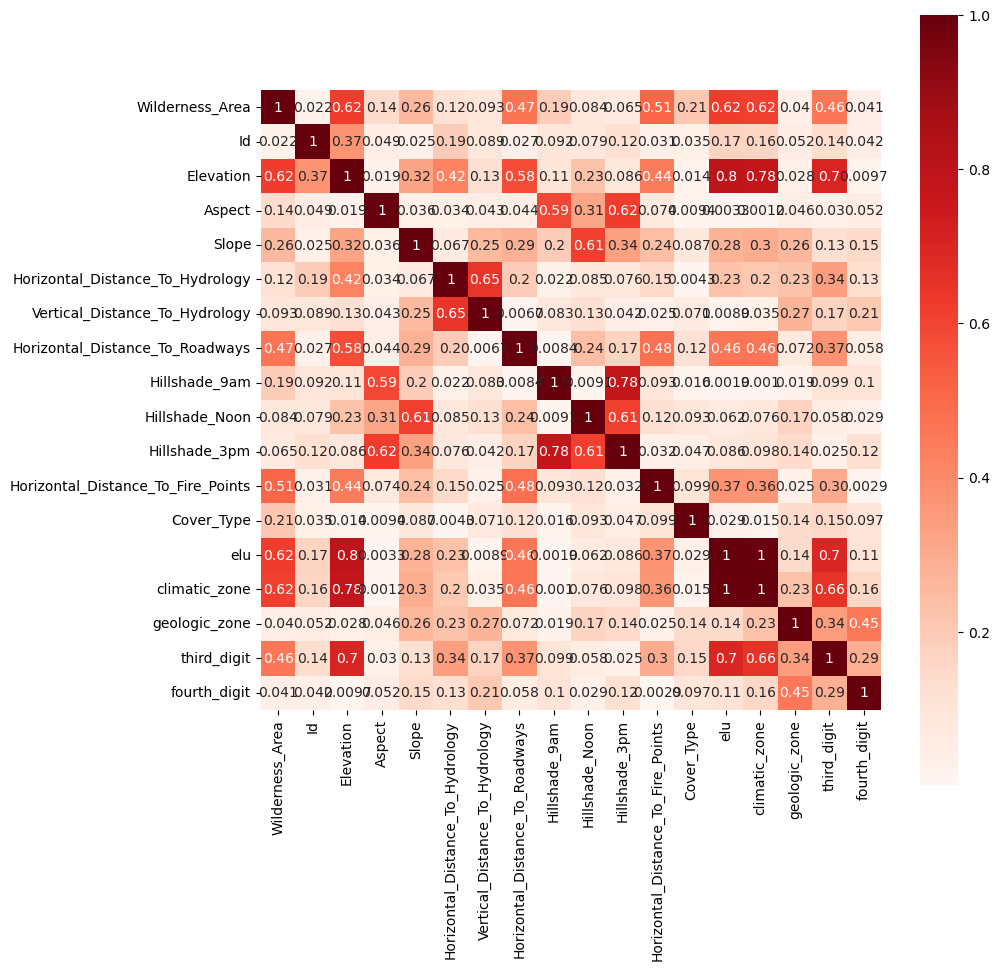

In [18]:
# Pearson Correlation: linear 
corr1 = df_train.corr(method='pearson').abs()
display(corr1)
plt.subplots(figsize = (10,10))
sns.heatmap(corr1,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

Wilderness_Area        Id  Elevation  \
Wilderness_Area                            1.000000  0.104358   0.726451   
Id                                         0.104358  1.000000   0.392686   
Elevation                                  0.726451  0.392686   1.000000   
Aspect                                     0.120607  0.043937   0.016463   
Slope                                      0.281104  0.038936   0.316397   
Horizontal_Distance_To_Hydrology           0.191194  0.203228   0.393976   
Vertical_Distance_To_Hydrology             0.070454  0.091501   0.099459   
Horizontal_Distance_To_Roadways            0.445891  0.138762   0.601193   
Hillshade_9am                              0.129036  0.105060   0.032726   
Hillshade_Noon                             0.117633  0.100022   0.205802   
Hillshade_3pm                              0.042895  0.115830   0.081953   
Horizontal_Distance_To_Fire_Points         0.524993  0.088107   0.513505   
Cover_Type                                 0.181058  0.040129   0.004001   
elu                                        0.619843  0.202829   0.810589   
climatic_zone                              0.649007  0.192926   0.814993   
geologic_zone                              0.042738  0.052572   0.022636   
third_digit                                0.462925  0.131094   0.669863   
fourth_digit                               0.049976  0.055952   0.002792   

                                      Aspect     Slope  \
Wilderness_Area                     0.120607  0.281104   
Id                                  0.043937  0.038936   
Elevation                           0.016463  0.316397   
Aspect                              1.000000  0.054185   
Slope                               0.054185  1.000000   
Horizontal_Distance_To_Hydrology    0.023830  0.008447   
Vertical_Distance_To_Hydrology      0.059509  0.325118   
Horizontal_Distance_To_Roadways     0.055157  0.289610   
Hillshade_9am                       0.410784  0.000347   
Hillshade_Noon                      0.398869  0.539254   
Hillshade_3pm                       0.617757  0.293881   
Horizontal_Distance_To_Fire_Points  0.078281  0.243083   
Cover_Type                          0.006411  0.093390   
elu                                 0.030901  0.244927   
climatic_zone                       0.031325  0.272710   
geologic_zone                       0.031441  0.274683   
third_digit                         0.027172  0.122141   
fourth_digit                        0.028371  0.158831   

                                    Horizontal_Distance_To_Hydrology  \
Wilderness_Area                                             0.191194   
Id                                                          0.203228   
Elevation                                                   0.393976   
Aspect                                                      0.023830   
Slope                                                       0.008447   
Horizontal_Distance_To_Hydrology                            1.000000   
Vertical_Distance_To_Hydrology                              0.694047   
Horizontal_Distance_To_Roadways                             0.145551   
Hillshade_9am                                               0.033542   
Hillshade_Noon                                              0.033826   
Hillshade_3pm                                               0.044010   
Horizontal_Distance_To_Fire_Points                          0.180931   
Cover_Type                                                  0.047955   
elu                                                         0.226003   
climatic_zone                                               0.182031   
geologic_zone                                               0.308171   
third_digit                                                 0.335823   
fourth_digit                                                0.203481   

                                    Vertical_Distance_To_Hydrology  \
Wilderness_Area                                  

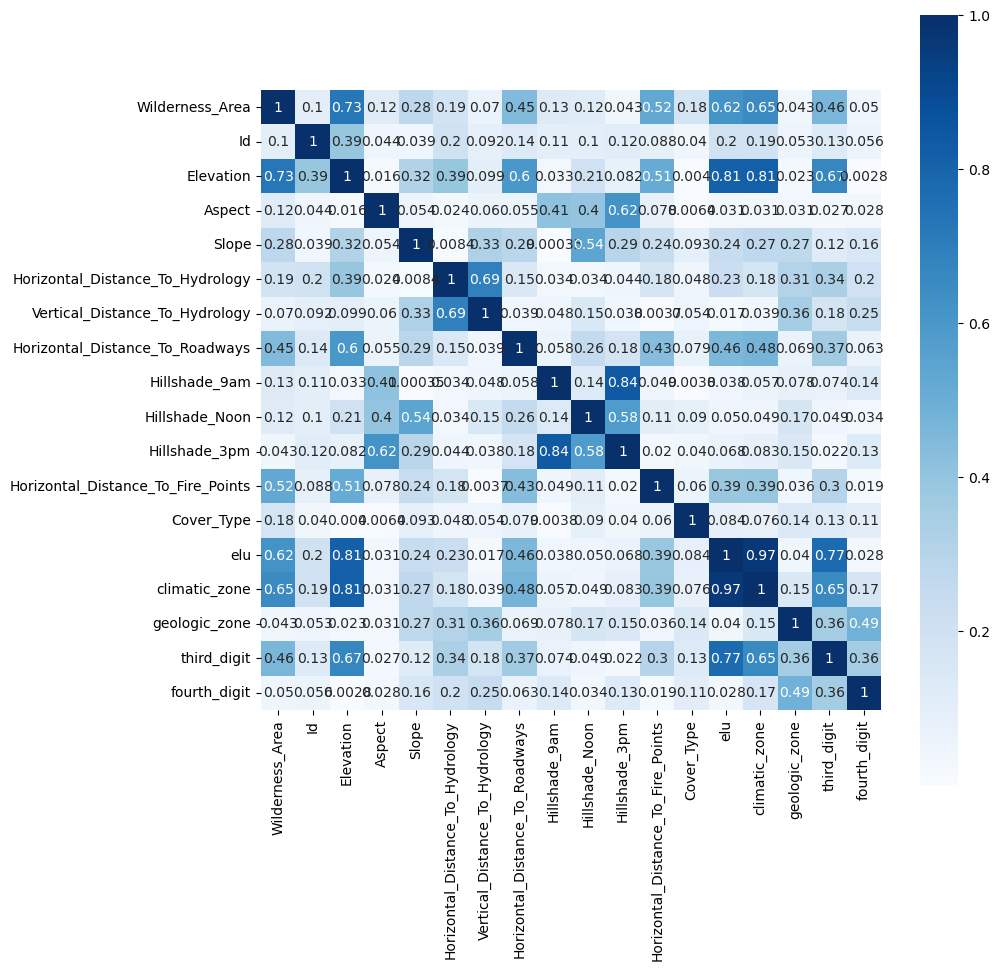

In [19]:
# Spearman Correlation: monotonicity
corr2 = df_train.corr(method='spearman').abs()
display(corr2)
plt.subplots(figsize = (10,10))
sns.heatmap(corr2, annot = True, vmax = 1, square = True, cmap = "Blues")
plt.show()

Id  Elevation    Aspect     Slope  \
Id                                  1.000000   0.392686  0.043937  0.038936   
Elevation                           0.392686   1.000000  0.016463  0.316397   
Aspect                              0.043937   0.016463  1.000000  0.054185   
Slope                               0.038936   0.316397  0.054185  1.000000   
Horizontal_Distance_To_Hydrology    0.203228   0.393976  0.023830  0.008447   
Vertical_Distance_To_Hydrology      0.091501   0.099459  0.059509  0.325118   
Horizontal_Distance_To_Roadways     0.138762   0.601193  0.055157  0.289610   
Hillshade_9am                       0.105060   0.032726  0.410784  0.000347   
Hillshade_Noon                      0.100022   0.205802  0.398869  0.539254   
Hillshade_3pm                       0.115830   0.081953  0.617757  0.293881   
Horizontal_Distance_To_Fire_Points  0.088107   0.513505  0.078281  0.243083   
Cover_Type                          0.040129   0.004001  0.006411  0.093390   

                                    Horizontal_Distance_To_Hydrology  \
Id                                                          0.203228   
Elevation                                                   0.393976   
Aspect                                                      0.023830   
Slope                                                       0.008447   
Horizontal_Distance_To_Hydrology                            1.000000   
Vertical_Distance_To_Hydrology                              0.694047   
Horizontal_Distance_To_Roadways                             0.145551   
Hillshade_9am                                               0.033542   
Hillshade_Noon                                              0.033826   
Hillshade_3pm                                               0.044010   
Horizontal_Distance_To_Fire_Points                          0.180931   
Cover_Type                                                  0.047955   

                                    Vertical_Distance_To_Hydrology  \
Id                                                        0.091501   
Elevation                                                 0.099459   
Aspect                                                    0.059509   
Slope                                                     0.325118   
Horizontal_Distance_To_Hydrology                          0.694047   
Vertical_Distance_To_Hydrology                            1.000000   
Horizontal_Distance_To_Roadways                           0.038912   
Hillshade_9am                                             0.047729   
Hillshade_Noon                                            0.151521   
Hillshade_3pm                                             0.037695   
Horizontal_Distance_To_Fire_Points                        0.003674   
Cover_Type                                                0.054427   

                                    Horizontal_Distance_To_Roadways  \
Id                                                         0.138762   
Elevation                                                  0.601193   
Aspect                                                     0.055157   
Slope                                                      0.289610   
Horizontal_Distance_To_Hydrology                           0.145551   
Vertical_Distance_To_Hydrology                             0.038912   
Horizontal_Distance_To_Roadways                            1.000000   
Hillshade_9am                                              0.058397   
Hillshade_Noon                                             0.256297   
Hillshade_3pm                                              0.178510   
Horizontal_Distance_To_Fire_Points                         0.432047   
Cover_Type                                                 0.078696   

                                    Hillshade_9am  Hillshade_Noon  \
Id                                       0.105060        0.100022   
Elevation                                0.032726        0.205802   
Aspect                             

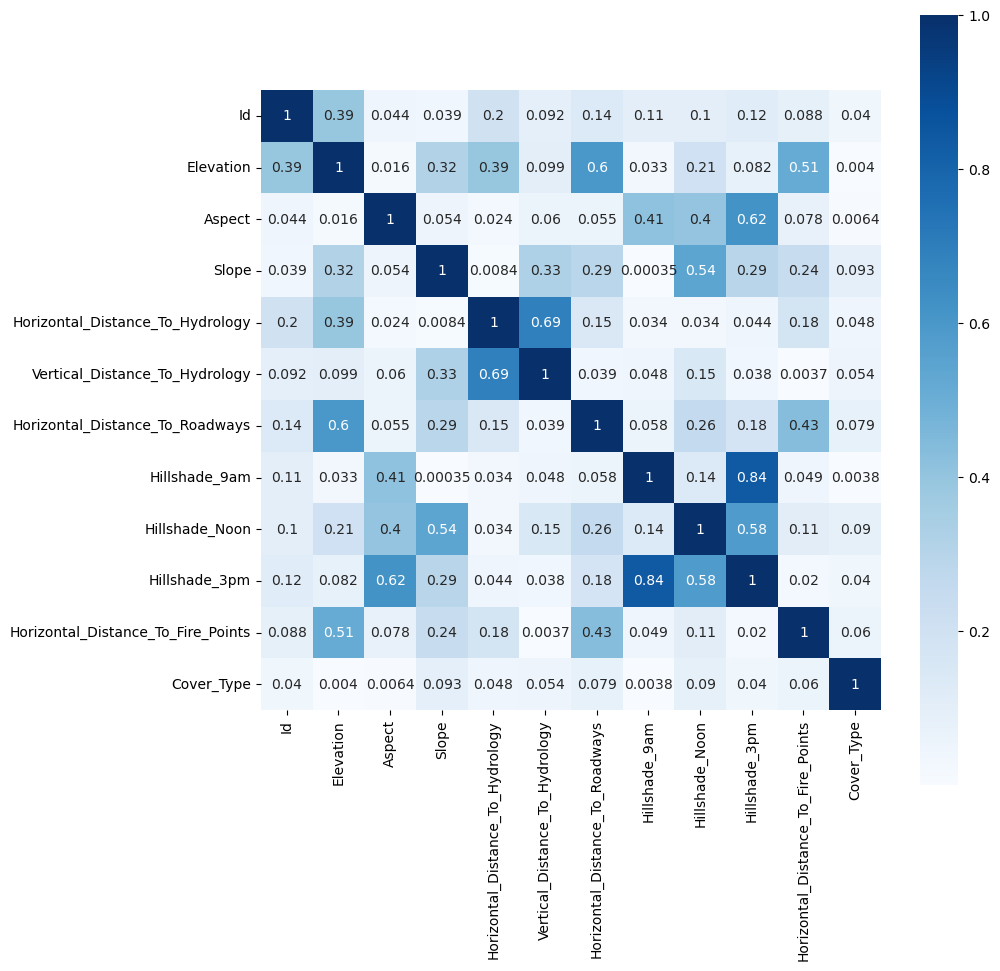

In [112]:
# Spearman Correlation: monotonicity
corr3 = df_train.iloc[:, 1:13].corr(method='spearman').abs()
display(corr3)
plt.subplots(figsize = (10,10))
sns.heatmap(corr3, annot = True, vmax = 1, square = True, cmap = "Blues")
plt.show()

In [26]:
def get_X_y(df_train):
    X = df_train[df_train.columns.difference(['Cover_Type'])]
    y = df_train['Cover_Type']
    return X,y

In [53]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', lgb.LGBMClassifier())
                     ])

param_grid = { 
}

model = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3)
X,y = get_X_y(df_train)
model.fit(X, y)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.885 total time=   1.6s
[CV 2/5] END ..................................., score=0.889 total time=   1.5s
[CV 3/5] END ..................................., score=0.897 total time=   1.5s
[CV 4/5] END ..................................., score=0.889 total time=   1.5s
[CV 5/5] END ..................................., score=0.888 total time=   1.5s


0.8894179894179894

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', lgb.LGBMClassifier())
                     ])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', LGBMClassifier())])

In [102]:
accuracy_score(y_train, pipeline.predict(X_train))

0.9939649470899471

In [103]:
accuracy_score(y_test, pipeline.predict(X_test))

0.8921957671957672

In [140]:
X_train_ca = X_train.copy()
for c in ['Wilderness_Area', 'elu', 'climatic_zone', 'geologic_zone', 'third_digit', 'fourth_digit']:
    X_train_ca[c] = X_train_ca[c].astype('category')

In [141]:
lgbc = lgb.LGBMClassifier()

In [142]:
lgbc.fit(X_train_ca,y_train)

LGBMClassifier()

In [143]:
accuracy_score(y_train, pipeline.predict(X_train_ca))

0.9939649470899471

In [144]:
accuracy_score(y_test, pipeline.predict(X_test))

0.8921957671957672

AxesSubplot(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Visualizing Important Features')

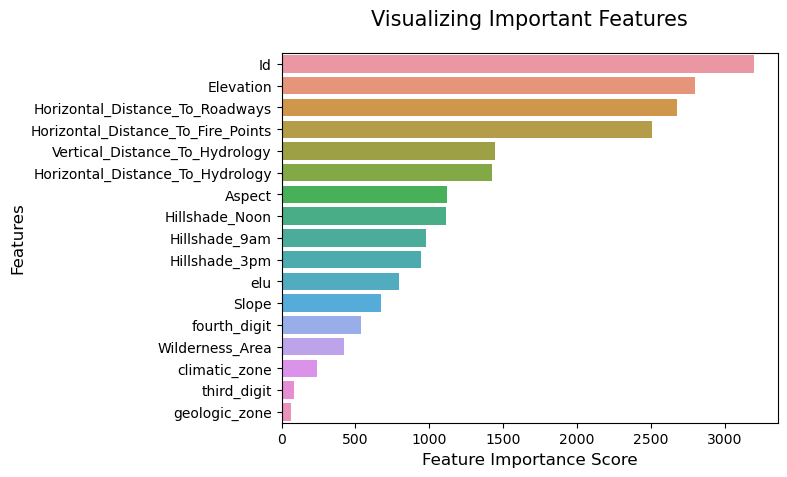

In [123]:
feature_imp = pd.Series(pipeline['classifier'].feature_importances_, 
                        index=X_train.columns).sort_values(ascending=False)

print(sns.barplot(x=feature_imp, y=feature_imp.index))
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Important Features", fontsize=15, pad=20)

In [48]:
def oneHot(df):
    df_oneHot = df.copy()
    for column in ['Wilderness_Area','climatic_zone','geologic_zone','third_digit','fourth_digit']:
        oneHot = pd.get_dummies(df[column], prefix=column)
        #print(oneHot)
        df_oneHot.drop(column,axis=1,inplace = True)
        df_oneHot =df_oneHot.join(oneHot)
    return df_oneHot

In [49]:
df_oneHot = oneHot(df_train)

In [50]:
df_oneHot

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0      242642       2881     130     22                               210   
1      309891       3005     351     14                               242   
2      287847       3226      63     14                               618   
3      516307       3298     317      8                               661   
4      124860       3080      35      6                               175   
...       ...        ...     ...    ...                               ...   
15115  475155       3328     321     13                               323   
15116  514378       3455      37      5                               841   
15117  368425       3279      90     14                               404   
15118  537844       3589     357      9                               418   
15119  463634       3385     345     15                               350   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                  54                             1020   
1                                 -16                             1371   
2                                   2                             1092   
3                                  60                              752   
4                                  26                             3705   
...                               ...                              ...   
15115                              12                             5109   
15116                              92                              939   
15117                             113                             1513   
15118                              52                             1868   
15119                              76                             3625   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  fourth_digit_0  \
0                250             221             88  ...               0   
1                194             215            159  ...               1   
2                232             210            107  ...               0   
3                198             233            174  ...               0   
4                219             227            144  ...               1   
...              ...             ...            ...  ...             ...   
15115            186             227            180  ...               0   
15116            220             229            146  ...               0   
15117            240             218            105  ...               0   
15118            205             223            155  ...               0   
15119            190             216            164  ...               0   

       fourth_digit_1  fourth_digit_2  fourth_digit_3  fourth_digit_4  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               1               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
15115               1               0               0               0   
15116               0               0               0               0   
15117               0               0               0               0   
15118               0               0               0               0   
15119               0               0               0               0   

       fourth_digit_5  fourth_digit_6  fourth_digit_7  fourth_digit_8  \
0                   0               1               0               0   
1                   0               0               0               0   
2                   1               0               0               0   
3                   0               0               0               0   
4                   0               0     

In [58]:
def show_result(df_train):
    pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', lgb.LGBMClassifier())
                     ])

    param_grid = { 
    }

    model = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3)
    X,y = get_X_y(df_train)
    model.fit(X, y)
    print(model.best_score_)

In [59]:
show_result(df_oneHot)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.884 total time=   2.4s
[CV 2/5] END ..................................., score=0.897 total time=   2.4s
[CV 3/5] END ..................................., score=0.895 total time=   2.2s
[CV 4/5] END ..................................., score=0.889 total time=   2.6s
[CV 5/5] END ..................................., score=0.886 total time=   2.4s
0.8900132275132275


In [200]:
def split_aspect(df):
    df_split = df.copy()
    df_split['aspect_m'] = df_split['Aspect'] + 180 - 75
    df_split.loc[df_split['aspect_m']>360, 'aspect_m'] = df_split.loc[df_split['aspect_m']>360,'aspect_m'] - 360
    return df_split

In [201]:
df_split = split_aspect(df_train)
show_result(df_split)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.879 total time=   1.9s
[CV 2/5] END ..................................., score=0.892 total time=   1.7s
[CV 3/5] END ..................................., score=0.894 total time=   1.6s
[CV 4/5] END ..................................., score=0.892 total time=   1.4s
[CV 5/5] END ..................................., score=0.883 total time=   1.6s
0.8878968253968254


<AxesSubplot: >

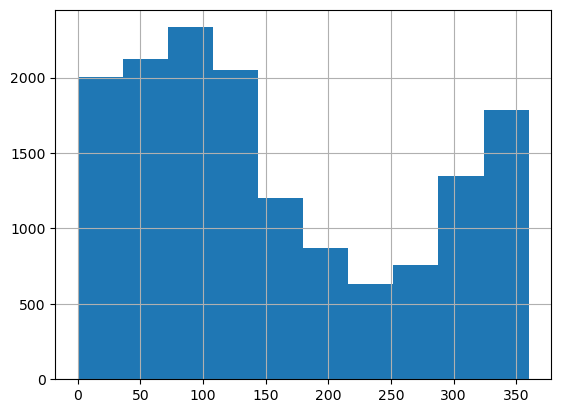

In [204]:
df_split['Aspect'].hist()

<AxesSubplot: >

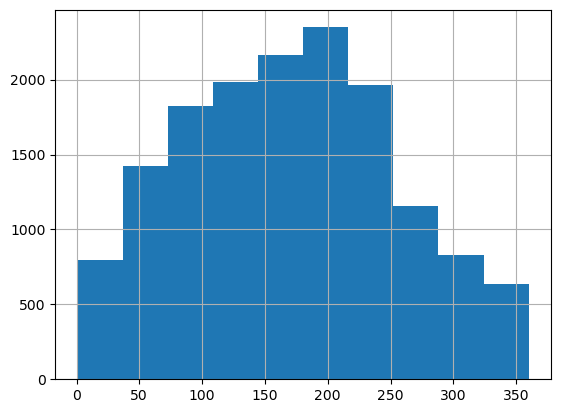

In [205]:
df_split['aspect_m'].hist()

In [108]:
def sqrt_col(df,col):
    df_sqrt = df.copy()
    df_sqrt['sqrt_'+col] = np.sqrt(df[col] + 1)
    return df_sqrt

In [109]:
df_sqrt = sqrt_col(df_train,'Horizontal_Distance_To_Hydrology')
show_result(df_sqrt)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.885 total time=   1.4s
[CV 2/5] END ..................................., score=0.889 total time=   1.4s
[CV 3/5] END ..................................., score=0.897 total time=   1.4s
[CV 4/5] END ..................................., score=0.893 total time=   1.4s
[CV 5/5] END ..................................., score=0.888 total time=   1.5s
0.8902116402116402


<AxesSubplot: >

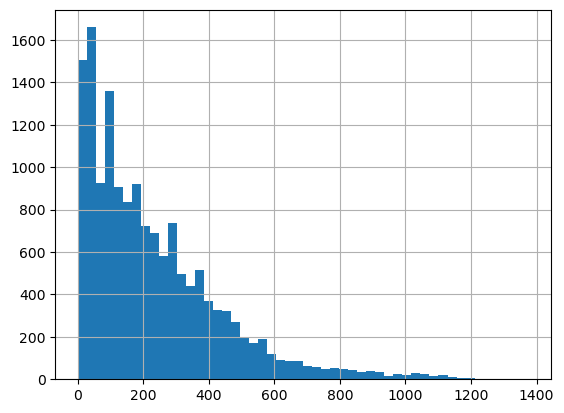

In [94]:
df_sqrt['Horizontal_Distance_To_Hydrology'].hist(bins=50)

<AxesSubplot: >

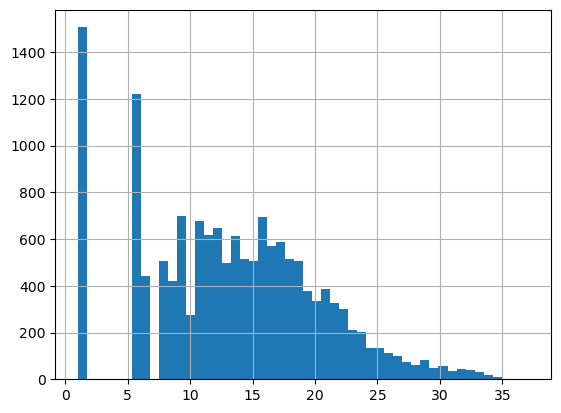

In [110]:
df_sqrt['sqrt_Horizontal_Distance_To_Hydrology'].hist(bins=50)

In [113]:
def drop_id(df):
    df_res = df.drop("Id", axis=1, inplace=False)
    return df_res

In [114]:
df_noid = drop_id(df_train)
show_result(df_noid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.851 total time=   1.4s
[CV 2/5] END ..................................., score=0.860 total time=   1.2s
[CV 3/5] END ..................................., score=0.865 total time=   1.4s
[CV 4/5] END ..................................., score=0.857 total time=   1.7s
[CV 5/5] END ..................................., score=0.850 total time=   1.4s
0.8566137566137566


In [115]:
def dist(df):
    df_res = df.copy()
    df_res['Distance'] = np.sqrt(df_res['Horizontal_Distance_To_Hydrology'] ** 2 + df_res['Vertical_Distance_To_Hydrology'] ** 2)
    return df_res

In [116]:
df_d = dist(df_train)
show_result(df_d)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.883 total time=   2.0s
[CV 2/5] END ..................................., score=0.892 total time=   2.0s
[CV 3/5] END ..................................., score=0.896 total time=   1.8s
[CV 4/5] END ..................................., score=0.894 total time=   1.8s
[CV 5/5] END ..................................., score=0.881 total time=   1.7s
0.8891534391534393


In [118]:
def rel_h(df,col):
    df_res = df.copy()
    df_res['relative_'+col] = df_res[col] / df_res['Elevation']
    return df_res

In [120]:
df_h = rel_h(df_train,'Horizontal_Distance_To_Hydrology')
show_result(df_h)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.881 total time=   1.4s
[CV 2/5] END ..................................., score=0.890 total time=   1.6s
[CV 3/5] END ..................................., score=0.893 total time=   1.4s
[CV 4/5] END ..................................., score=0.894 total time=   1.5s
[CV 5/5] END ..................................., score=0.885 total time=   1.4s
0.8885582010582009


In [124]:
df_train.columns

Index(['Wilderness_Area', 'Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Cover_Type',
       'elu', 'climatic_zone', 'geologic_zone', 'third_digit', 'fourth_digit'],
      dtype='object')

In [174]:
def reduce_id(df):
    df_res = df.copy()
    df_res['reduce_id'] = df_res['Id'] // 100
    df_res = df_res.drop('Id',axis=1)
    return df_res

In [222]:
df_final = split_aspect(df_train)
df_final = oneHot(df_final)
df_final = sqrt_col(df_final,'Horizontal_Distance_To_Hydrology')
df_final = sqrt_col(df_final,'Horizontal_Distance_To_Roadways')
df_final = sqrt_col(df_final,'Horizontal_Distance_To_Fire_Points')
df_final = dist(df_final)
df_final = rel_h(df_final,'Horizontal_Distance_To_Roadways')
df_final = rel_h(df_final,'Horizontal_Distance_To_Fire_Points')
#df_final = reduce_id(df_final)

In [223]:
df_final

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0      242642       2881     130     22                               210   
1      309891       3005     351     14                               242   
2      287847       3226      63     14                               618   
3      516307       3298     317      8                               661   
4      124860       3080      35      6                               175   
...       ...        ...     ...    ...                               ...   
15115  475155       3328     321     13                               323   
15116  514378       3455      37      5                               841   
15117  368425       3279      90     14                               404   
15118  537844       3589     357      9                               418   
15119  463634       3385     345     15                               350   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                  54                             1020   
1                                 -16                             1371   
2                                   2                             1092   
3                                  60                              752   
4                                  26                             3705   
...                               ...                              ...   
15115                              12                             5109   
15116                              92                              939   
15117                             113                             1513   
15118                              52                             1868   
15119                              76                             3625   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  fourth_digit_6  \
0                250             221             88  ...               1   
1                194             215            159  ...               0   
2                232             210            107  ...               0   
3                198             233            174  ...               0   
4                219             227            144  ...               0   
...              ...             ...            ...  ...             ...   
15115            186             227            180  ...               0   
15116            220             229            146  ...               1   
15117            240             218            105  ...               0   
15118            205             223            155  ...               1   
15119            190             216            164  ...               1   

       fourth_digit_7  fourth_digit_8  fourth_digit_9  \
0                   0               0               0   
1                   0               0               0   
2                   0               0               0   
3                   0               0               0   
4                   0               0               0   
...               ...             ...             ...   
15115               0               0               0   
15116               0               0               0   
15117               0               0               0   
15118               0               0               0   
15119               0               0               0   

       sqrt_Horizontal_Distance_To_Hydrology  \
0                                  14.525839   
1                                  15.588457   
2                                  24.879711   
3                                  25.729361   
4                                  13.266499   
...                                      ...   
15115                              18.000000   
15116                              29.017236   
15117                              20.124612   
15118                              20.469489   
15119                              18.734994   

       sqrt_Horizontal

In [224]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X,y = get_X_y(df_final)
X = sel.fit_transform(X)
pipeline = Pipeline([('scaler', StandardScaler()),
                 ('classifier', lgb.LGBMClassifier())
                 ])

param_grid = { 
}

model = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3)

model.fit(X, y)
print(model.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.880 total time=   2.2s
[CV 2/5] END ..................................., score=0.889 total time=   1.9s
[CV 3/5] END ..................................., score=0.893 total time=   1.9s
[CV 4/5] END ..................................., score=0.892 total time=   1.9s
[CV 5/5] END ..................................., score=0.884 total time=   1.9s
0.8875661375661374


In [221]:
show_result(df_final)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [183]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', lgb.LGBMClassifier())
                     ])

param_grid = { 
}

model = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3)
X,y = get_X_y(df_final)
model.fit(X, y)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.890 total time=   3.1s
[CV 2/5] END ..................................., score=0.898 total time=   3.3s
[CV 3/5] END ..................................., score=0.890 total time=   3.3s
[CV 4/5] END ..................................., score=0.894 total time=   3.3s
[CV 5/5] END ..................................., score=0.887 total time=   2.4s


0.8915343915343914

AxesSubplot(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Visualizing Important Features')

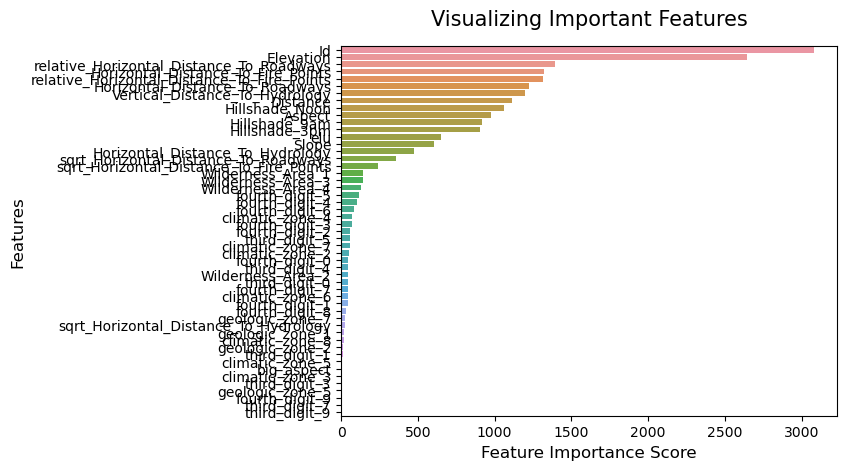

In [157]:
feature_imp = pd.Series(model.best_estimator_['classifier'].feature_importances_, 
                        index=X.columns).sort_values(ascending=False)

print(sns.barplot(x=feature_imp, y=feature_imp.index))
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Important Features", fontsize=15, pad=15)

In [187]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', lgb.LGBMClassifier())
                     ])

param_grid = { 
    'classifier__max_bin': [327],
    'classifier__learning_rate': [0.4],
    'classifier__num_leaves': [63],
    'classifier__n_estimators': [300]
}

model = GridSearchCV(pipeline, param_grid, scoring='accuracy', verbose=3)
X,y = get_X_y(df_final)
model.fit(X, y)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__learning_rate=0.4, classifier__max_bin=327, classifier__n_estimators=300, classifier__num_leaves=63;, score=0.891 total time=   6.4s
[CV 2/5] END classifier__learning_rate=0.4, classifier__max_bin=327, classifier__n_estimators=300, classifier__num_leaves=63;, score=0.903 total time=   5.9s
[CV 3/5] END classifier__learning_rate=0.4, classifier__max_bin=327, classifier__n_estimators=300, classifier__num_leaves=63;, score=0.899 total time=   6.7s
[CV 4/5] END classifier__learning_rate=0.4, classifier__max_bin=327, classifier__n_estimators=300, classifier__num_leaves=63;, score=0.903 total time=   6.7s
[CV 5/5] END classifier__learning_rate=0.4, classifier__max_bin=327, classifier__n_estimators=300, classifier__num_leaves=63;, score=0.898 total time=   5.9s


0.8988095238095237

In [161]:
df_test = pd.read_csv("./data/test-full.csv")
df_test = preprocess_df(df_test)
ids = df_test['Id']

array([[<AxesSubplot: title={'center': 'Wilderness_Area'}>,
        <AxesSubplot: title={'center': 'Id'}>,
        <AxesSubplot: title={'center': 'Elevation'}>,
        <AxesSubplot: title={'center': 'Aspect'}>],
       [<AxesSubplot: title={'center': 'Slope'}>,
        <AxesSubplot: title={'center': 'Horizontal_Distance_To_Hydrology'}>,
        <AxesSubplot: title={'center': 'Vertical_Distance_To_Hydrology'}>,
        <AxesSubplot: title={'center': 'Horizontal_Distance_To_Roadways'}>],
       [<AxesSubplot: title={'center': 'Hillshade_9am'}>,
        <AxesSubplot: title={'center': 'Hillshade_Noon'}>,
        <AxesSubplot: title={'center': 'Hillshade_3pm'}>,
        <AxesSubplot: title={'center': 'Horizontal_Distance_To_Fire_Points'}>],
       [<AxesSubplot: title={'center': 'elu'}>,
        <AxesSubplot: title={'center': 'climatic_zone'}>,
        <AxesSubplot: title={'center': 'geologic_zone'}>,
        <AxesSubplot: title={'center': 'third_digit'}>],
       [<AxesSubplot: title={'ce

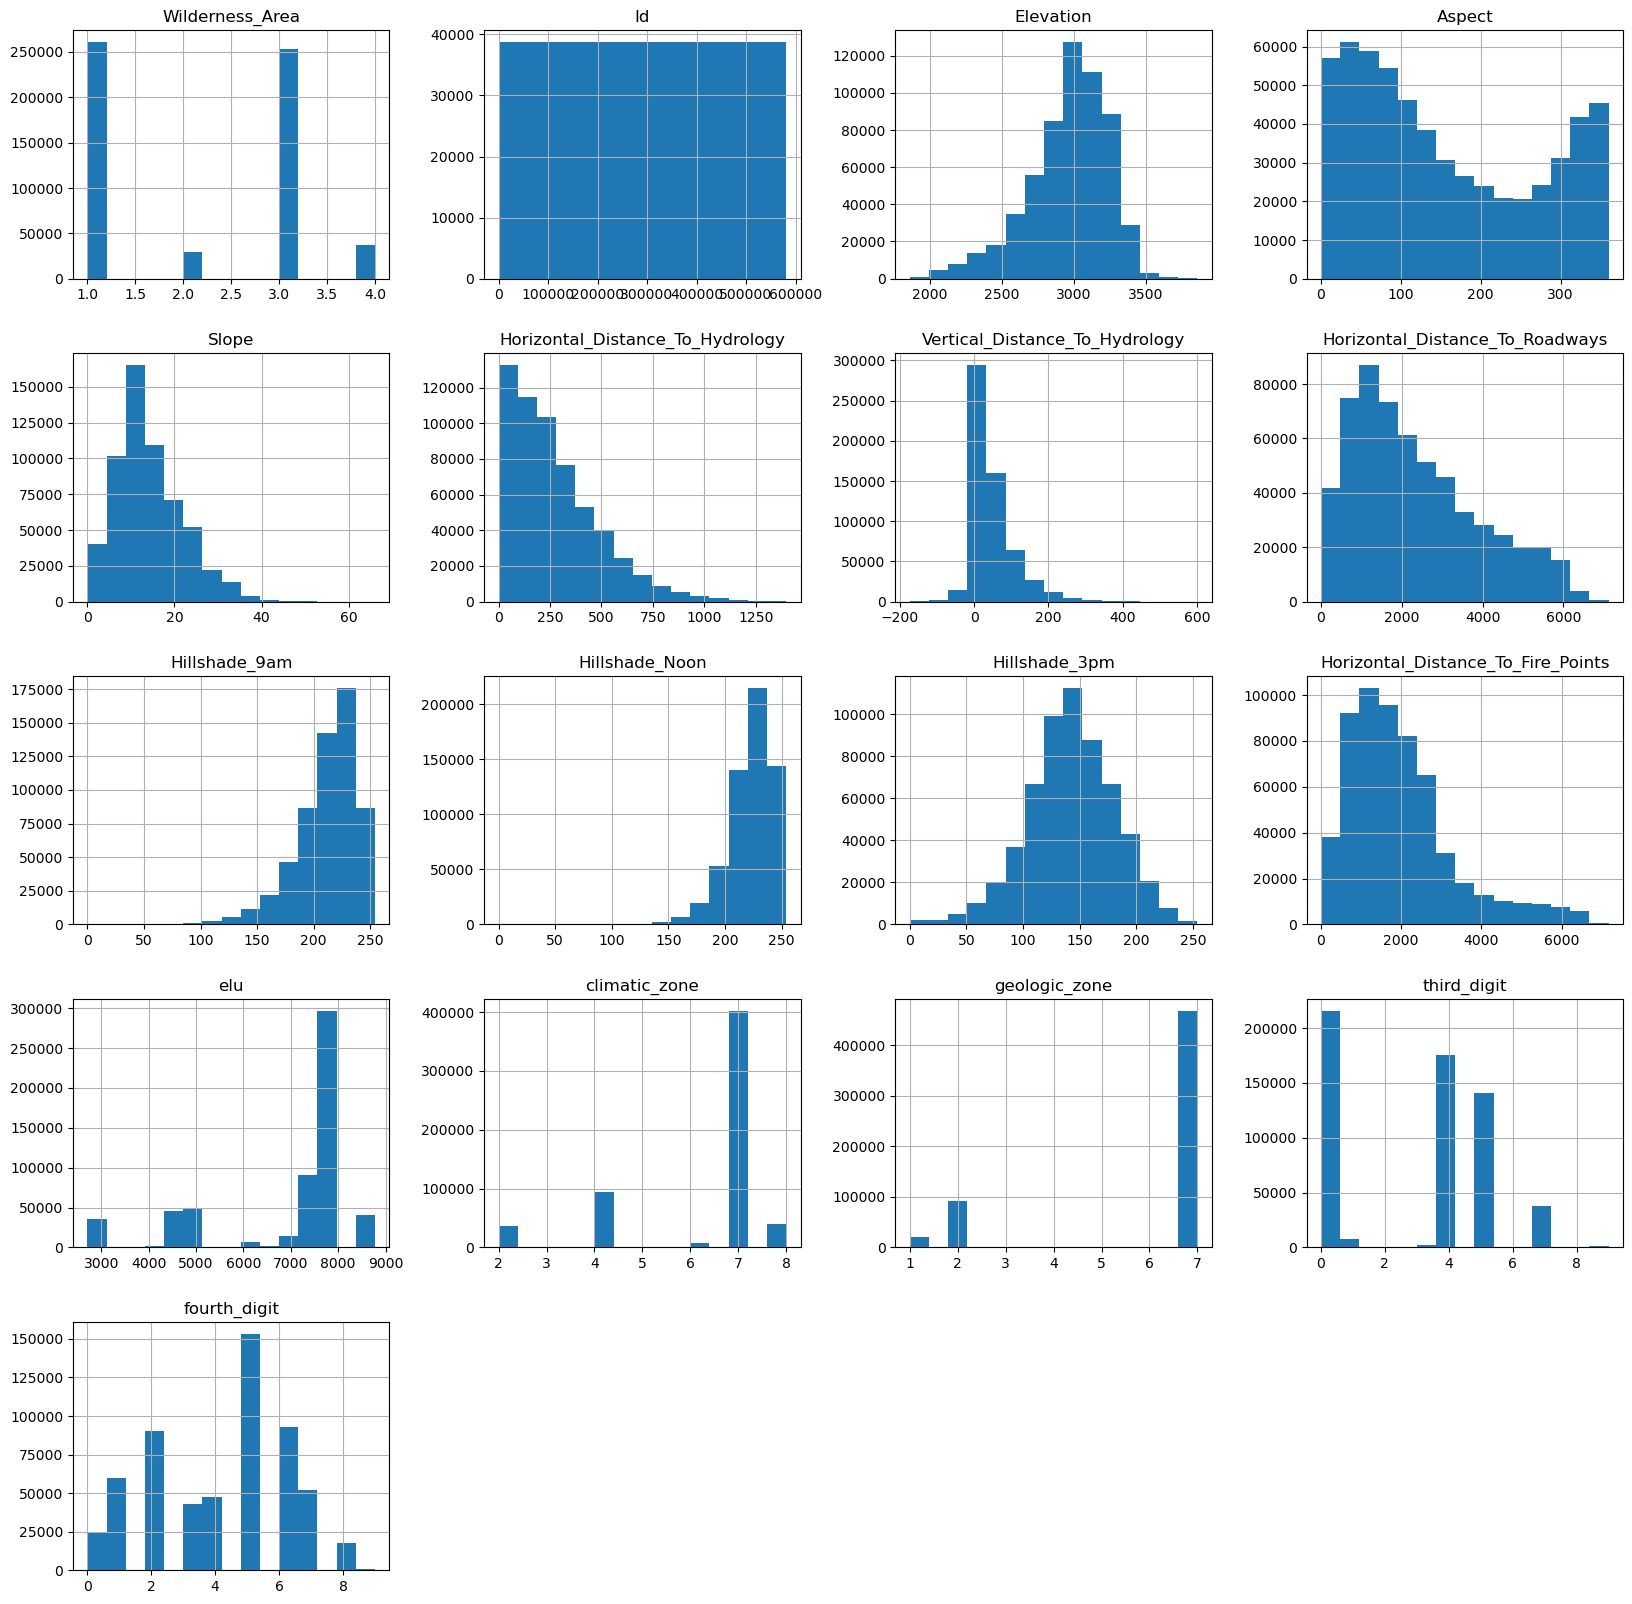

In [191]:
df_test.hist(figsize=(20,20),bins=15)

In [188]:
df_final = split_aspect(df_test)
df_final = oneHot(df_final)
df_final = sqrt_col(df_final,'Horizontal_Distance_To_Hydrology')
df_final = sqrt_col(df_final,'Horizontal_Distance_To_Roadways')
df_final = sqrt_col(df_final,'Horizontal_Distance_To_Fire_Points')
df_final = dist(df_final)
df_final = rel_h(df_final,'Horizontal_Distance_To_Roadways')
df_final = rel_h(df_final,'Horizontal_Distance_To_Fire_Points')
# df_final = reduce_id(df_final)

In [189]:
best_model = model.best_estimator_
y_test = best_model.predict(df_final[X.columns])
df_result = pd.DataFrame(list(zip(ids, y_test)), columns=['Id', 'Cover_Type'])
df_result.to_csv("./data/lgbm_feature_pred.csv", index=False)

In [164]:
X.columns

Index(['Aspect', 'Distance', 'Elevation', 'Hillshade_3pm', 'Hillshade_9am',
       'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points',
       'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Id', 'Slope', 'Vertical_Distance_To_Hydrology', 'Wilderness_Area_1',
       'Wilderness_Area_2', 'Wilderness_Area_3', 'Wilderness_Area_4',
       'big_aspect', 'climatic_zone_2', 'climatic_zone_3', 'climatic_zone_4',
       'climatic_zone_5', 'climatic_zone_6', 'climatic_zone_7',
       'climatic_zone_8', 'elu', 'fourth_digit_0', 'fourth_digit_1',
       'fourth_digit_2', 'fourth_digit_3', 'fourth_digit_4', 'fourth_digit_5',
       'fourth_digit_6', 'fourth_digit_7', 'fourth_digit_8', 'fourth_digit_9',
       'geologic_zone_1', 'geologic_zone_2', 'geologic_zone_5',
       'geologic_zone_7', 'relative_Horizontal_Distance_To_Fire_Points',
       'relative_Horizontal_Distance_To_Roadways',
       'sqrt_Horizontal_Distance_To_Fire_Points',
       'sqrt_Horizontal_Dista

In [167]:
df_final[X.columns]

Aspect    Distance  Elevation  Hillshade_3pm  Hillshade_9am  \
0           51  258.000000       2596            148            221   
1           56  212.084889       2590            151            220   
2          139  275.769832       2804            135            234   
3          155  269.235956       2785            122            238   
4           45  153.003268       2595            150            220   
...        ...         ...        ...            ...            ...   
581007     153   86.683332       2396            118            240   
581008     152   68.066144       2391            119            240   
581009     159   60.406953       2386            130            236   
581010     170   60.207973       2384            143            230   
581011     165   60.133186       2383            141            231   

        Hillshade_Noon  Horizontal_Distance_To_Fire_Points  \
0                  232                                6279   
1                  235                                6225   
2                  238                                6121   
3                  238                                6211   
4                  234                                6172   
...                ...                                 ...   
581007             237                                 837   
581008             237                                 845   
581009             241                                 854   
581010             245                                 864   
581011             244                                 875   

        Horizontal_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                    258                              510   
1                                    212                              390   
2                                    268                             3180   
3                                    242                             3090   
4                                    153                              391   
...                                  ...                              ...   
581007                                85                              108   
581008                                67                               95   
581009                                60                               90   
581010                                60                               90   
581011                                60                               67   

            Id  ...  sqrt_Horizontal_Distance_To_Fire_Points  \
0            1  ...                                18.520259   
1            2  ...                                29.034462   
2            3  ...                                44.933284   
3            4  ...                                35.341194   
4            5  ...                                51.710734   
...        ...  ...                                      ...   
581007  581008  ...                                      NaN   
581008  581009  ...                                      NaN   
581009  581010  ...                                      NaN   
581010  581011  ...                                      NaN   
581011  581012  ...                                      NaN   

        sqrt_Horizontal_Distance_To_Hydrology  \
0                                   14.525839   
1                                   15.588457   
2                                   24.879711   
3                                   25.729361   
4                                   13.266499   
...                                       ...   
581007                                    NaN   
581008                                    NaN   
581009                                    NaN   
581010                                    NaN   
581011                                    NaN   

        sqrt_Horizontal_Distance_To_Roadways  third_digit_0  third_digit_1  \
0                                  31.953091     